### Method to reproduce the problem with iterations

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import torch
from neuralNet import FeedForwardNet, jacobian, hessian, m2a, a2m
import numpy as np
import crocoddyl
from validation import validate_and_plot
from utils import circular

Mean Squared Error during testing is 0.0071262153796851635
......................................................................
Plotting scatter of error between ddp.cost and cost predicted by Neural Net


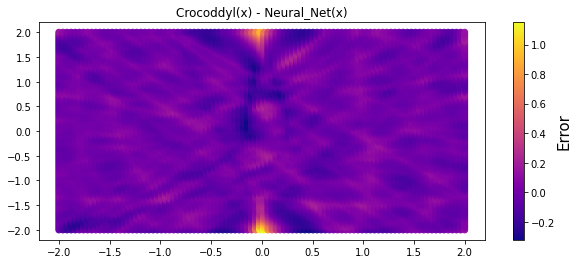

In [9]:
torchnet = torch.load("Network.pth")
validate_and_plot(torchnet, plot_data=False, plot_error=True)

In [12]:
class UnicycleTerminal(crocoddyl.ActionModelAbstract):
    """
    This class is the terminal model for unicycle crocoddyl with neural net inside it.
    
    Given a state x, the neural net predicts the value function in the calc.
            # net(x) = data.cost
            
    Given the state x, the jacobian and hessian of the net(x) with respect to x are calculated
            # jacobian(net(x), x) = data.Lx
            # hessian(net(x), x)  = data.Lxx
    
    """
    def __init__(self, net):
        """
        @params
            1: network
        
        usage: terminal_model = UnicycleTerminal(net)   
        
        """
        crocoddyl.ActionModelAbstract.__init__(self, crocoddyl.StateVector(3), 2, 5)
        self.net = net
        
        
    def calc(self, data, x, u=None):
        
        x = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        
        with torch.no_grad():
            data.cost = self.net(x).item()

    def calcDiff(self, data, x, u=None):
        
        if u is None:
            u = self.unone
        
        x0 = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        
        x0.requires_grad_(True)
        
        j = jacobian(self.net(x0), x0)        
        h = hessian(self.net(x0), x0)
        
        data.Lx = a2m(j.detach().numpy())
        data.Lxx = a2m(h.detach().numpy())

In [86]:
nTrajectories = 100
iters         = []
cost          = []
xs            = []

xtest = circular()

model = crocoddyl.ActionModelUnicycle()
T = 30
model.costWeights = np.matrix([1,1]).T
modelValueTerminal = UnicycleTerminal(torchnet)

#for xyz in xtest:
    
for _ in range(nTrajectories):
    
    xyz = [np.random.uniform(-2.1, 2.1), 
           np.random.uniform(-2.1, 2.1),
           0]
    
    # Solve the problem for crocoddyl with torch network
    problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, modelValueTerminal)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [], maxiter = 1000)

    cost.append(ddp.cost)
    iters.append(ddp.iter)
    
    xs_ = np.array(ddp.xs)
    ddp_xs = xs_[:,0:2]
    xs.append(ddp_xs)

        
        


In [58]:
# Lets plot the trajectories which took 100 iterations

In [83]:
def plot_trajectories(cost, trajectories, name = "Cost"):
    """
    
    @params:
        cost           = list of keys for cmap
        trajectories   = list of corresponding trajectories
        name           = str, to distinguish between cost and iterations
        
    @ returns plot of trajectories colored according to keys.    
    
    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.dpi'] = 80
    fig = plt.figure(figsize=(8, 6))

    norm = mpl.colors.Normalize(vmin=float(min(cost)), vmax=float(max(cost)))
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.plasma)
    cmap.set_array([])


    for key, trajectory in zip(cost, trajectories):
        plt.scatter(trajectory[:, 0], trajectory[:, 1], 
                    marker = '',
                    zorder=2, 
                    s=50,
                    linewidths=0.2,
                    alpha=.8, 
                    cmap = cmap )
        plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))

    plt.xlabel("X Coordinates", fontsize = 20)
    plt.ylabel("Y Coordinates", fontsize = 20)
    plt.colorbar(cmap).set_label(name, labelpad=2, size=15)
    plt.show()

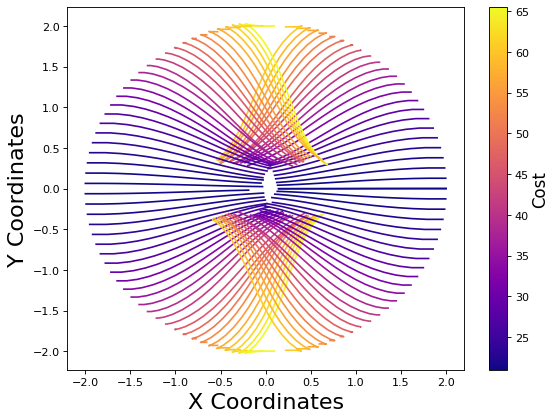

In [84]:
plot_trajectories(cost, xs)

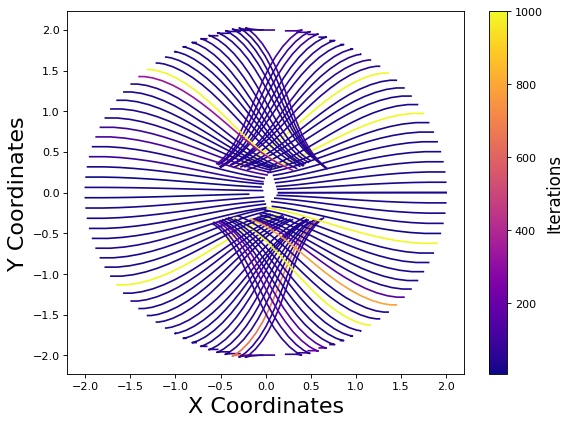

In [85]:
plot_trajectories(iters, xs, name = "Iterations")